# Introduction

The following notebook shows our work on the classifier committee, which connects created models in order to get even better results.

## Prepare Environment

In [4]:
import os
import torch
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc
from torch.utils.data import DataLoader

from measures import ModelType
from measures import MeasureToolFactory
from dataset.dataset_info import ClassifierDatasetInfo, MMClassifierDatasetInfo
from dataset.dataset_type import DatasetType
from dataset.STARCOP_dataset import STARCOPDataset
from files_handler import ModelFilesHandler

os.chdir(r"../..")
device = "cuda" if torch.cuda.is_available() else "cpu"

## Prepare dataloaders

In [5]:
dataset = STARCOPDataset(
    data_path=r"data",
    data_type=DatasetType.TEST,
    image_info_class=ClassifierDatasetInfo,
    normalization=False
)
dataloader = DataLoader(dataset, batch_size=6, shuffle=False)

mm_dataset = STARCOPDataset(
    data_path=r"data",
    data_type=DatasetType.TEST,
    image_info_class=MMClassifierDatasetInfo,
    normalization=False
)
mm_dataloader = DataLoader(mm_dataset, batch_size=6, shuffle=False)

model_handler = ModelFilesHandler()

## CNN

In [6]:
file_name = r"best_models\CNN\model_cnn_2024_12_14_13_20_07.pickle"
model, _, _, _ = model_handler.load_model(file_name=file_name)

model.eval()
model.to(device)

current_labels = []
current_predictions = []
current_probabilities = []
for batch_id, (images, mag1c, labels) in enumerate(dataloader):
    input_image = torch.cat((images, mag1c), dim=1).to(device)
    labels = labels.long().to(device)

    outputs = model(input_image)
    probabilities = torch.softmax(outputs, dim=1)[:, 1]
    predictions = torch.argmax(outputs, dim=1)

    current_labels.append(labels.cpu().detach())
    current_predictions.append(predictions.cpu().detach())
    current_probabilities.append(probabilities.cpu().detach())

model.to("cpu")
all_labels = torch.cat(current_labels)
all_predictions = torch.cat(current_predictions)
all_probabilities = torch.cat(current_probabilities)
print("CNN finished.")

CNN finished.


## DETR

In [7]:
file_name = r"best_models\DETR\model_detr_2024_12_15_11_35_17.pickle"
model, _, _, _ = model_handler.load_model(file_name=file_name)

model.eval()
model.to(device)

current_predictions = []
current_probabilities = []
for batch_id, (images, mag1c, labels) in enumerate(dataloader):
    input_image = torch.cat((images, mag1c), dim=1).to(device)
    labels = labels.long().to(device)

    outputs = model(input_image)
    probabilities = torch.softmax(outputs, dim=1)[:, 1]
    predictions = torch.argmax(outputs, dim=1)

    current_predictions.append(predictions.cpu().detach())
    current_probabilities.append(probabilities.cpu().detach())

model.to("cpu")
all_predictions = torch.add(all_predictions, torch.cat(current_predictions))
all_probabilities = torch.add(all_probabilities, torch.cat(current_probabilities))
print("DETR finished.")

D:\Projects\studia\polsl_ssi_1\MethaneDetection\Thesis\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DETR finished.


## MethaneMapper

In [8]:
file_name = r"best_models\MethaneMapper\model_transformer_classifier_2024_12_02_00_37_54.pickle"
model, _, _, _ = model_handler.load_model(file_name=file_name)

model.eval()
model.to(device)

current_predictions = []
current_probabilities = []
for batch_id, (images, mag1c, filtered_image, labels) in enumerate(mm_dataloader):
    input_image = torch.cat((images, mag1c), dim=1).to(device)
    filtered_image = filtered_image.to(device)
    labels = labels.long().to(device)

    outputs = model(input_image, filtered_image)
    probabilities = torch.softmax(outputs, dim=1)[:, 1]
    predictions = torch.argmax(outputs, dim=1)

    current_predictions.append(predictions.cpu().detach())
    current_probabilities.append(probabilities.cpu().detach())

model.to("cpu")
all_predictions = torch.add(all_predictions, torch.cat(current_predictions))
all_probabilities = torch.add(all_probabilities, torch.cat(current_probabilities))
print("Methane mapper finished.")

Methane mapper finished.


## ViT

In [9]:
file_name = r"best_models\VIT\model_vit_2024_12_15_11_50_56.pickle"
model, _, _, _ = model_handler.load_model(file_name=file_name)

model.eval()
model.to(device)

current_predictions = []
current_probabilities = []
for batch_id, (images, mag1c, labels) in enumerate(dataloader):
    input_image = torch.cat((images, mag1c), dim=1).to(device)
    labels = labels.long().to(device)

    outputs = model(input_image)
    probabilities = torch.softmax(outputs, dim=1)[:, 1]
    predictions = torch.argmax(outputs, dim=1)

    current_predictions.append(predictions.cpu().detach())
    current_probabilities.append(probabilities.cpu().detach())

model.to("cpu")
all_predictions = torch.add(all_predictions, torch.cat(current_predictions))
all_probabilities = torch.add(all_probabilities, torch.cat(current_probabilities))
print("VIT finished.")

VIT finished.


## Prepare conclusions

In [10]:
csv_path = r"notebooks/experiments/classifier_committee_measures.csv"
measurer = MeasureToolFactory.get_measure_tool(ModelType.TRANSFORMER)
labels = all_labels[:]

columns = [
    'conclusion_type','tp', 'fp', 'fn', 'tn', 'precision', 'sensitivity',
    'specificity', 'npv', 'fpr', 'accuracy', 'fscore', 'iou', 'mcc', 'auc', 'ci',
]

df = pd.DataFrame(columns=columns)
df.to_csv(csv_path, index=False)

def measure_and_save(min_detections):
    pred = torch.Tensor([int(x >= min_detections) for x in all_predictions])
    measures = measurer.compute_measures(pred, labels)
    print(measures)

    conclusion_info = f"at least {min_detections} detection{"s" if min_detections > 1 else ""}"
    measure_info = pd.DataFrame.from_dict({"conculsion_type":[conclusion_info]})

    row = pd.concat([measure_info, measures], axis=1)
    row.to_csv(csv_path, mode='a', index=False, header=False)

## Conclusion - at least 1 detection

In [11]:
measure_and_save(min_detections=1)

        TP        FP        FN        TN  Precision  Sensitivity  Specificity  \
0  0.48538  0.049708  0.002924  0.461988   0.907102      0.99401     0.902855   

        NPV       FPR  Accuracy   F-Score       IoU       MCC       AUC  \
0  0.993709  0.097143  0.947367  0.948569  0.902174  0.898836  0.948435   

         CI  
0  0.052939  


## Conclusion - at least 2 detections

In [12]:
measure_and_save(min_detections=2)


         TP        FP        FN        TN  Precision  Sensitivity  \
0  0.464912  0.002924  0.023392  0.508772   0.993748     0.952094   

   Specificity       NPV       FPR  Accuracy   F-Score       IoU       MCC  \
0     0.994284  0.956042  0.005714  0.973683  0.972475  0.946429  0.948082   

        AUC       CI  
0  0.973191  0.05296  


## Conclusion - at least 3 detections

In [13]:
measure_and_save(min_detections=3)


         TP   FP        FN        TN  Precision  Sensitivity  Specificity  \
0  0.418129  0.0  0.070175  0.511696   0.999998     0.856286     0.999998   

        NPV  FPR  Accuracy   F-Score       IoU       MCC       AUC        CI  
0  0.879395  0.0  0.929824  0.922578  0.856287  0.867762  0.928144  0.052354  


## Conclusion - at least 4 detections

In [14]:
measure_and_save(min_detections=4)

         TP   FP        FN        TN  Precision  Sensitivity  Specificity  \
0  0.298246  0.0  0.190058  0.511696   0.999997     0.610777     0.999998   

        NPV  FPR  Accuracy   F-Score       IoU      MCC       AUC        CI  
0  0.729166  0.0  0.809941  0.758362  0.610778  0.66735  0.805389  0.048558  


## Create ROC curve

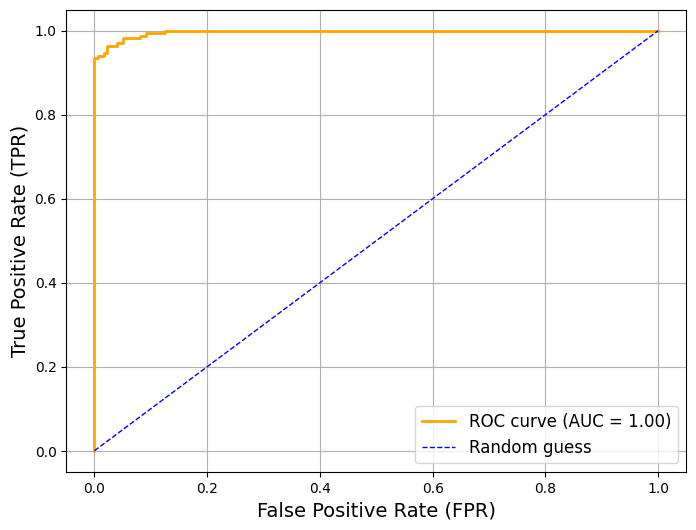

In [16]:
fixed_all_probabilities = all_probabilities/4
fpr, tpr, thresholds = roc_curve(all_labels, fixed_all_probabilities)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='orange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='blue', lw=1, linestyle='--', label="Random guess")

plt.xlabel("False Positive Rate (FPR)", fontsize=14)
plt.ylabel("True Positive Rate (TPR)", fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)
plt.show()

## Restore environment

In [17]:
os.chdir(r".\notebooks\experiments")